# Radial Advection Example (MFEM Example 9)

In [35]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from itertools import product
import sys,time
import pickle
import os
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from WLaSDI import WLaSDI
from WLaSDI_wendy import  WLaSDI_wendy
import matplotlib
from scipy.interpolate import interp2d, Rbf
import matplotlib

### Import training simulations, parameters, etc.

In [36]:
# ### Load Data if Model Already Exists ###
snapshot_full = np.array([])
Training_values = [100, 105, 110, 115, 120, 125, 130, 135, 140]
for i in Training_values:
    ex = np.load('./data/ex9_interp_{}.npz'.format(int(i)), allow_pickle = True)
    ex = ex.f.arr_0
    snapshot_full = np.append(snapshot_full, ex)
snapshot_full = snapshot_full.reshape(len(Training_values)*240,-1)
# snapshot_full = snapshot_full.T
nx = 64
ny = 64
m = (ny-2)*(nx-2) # 3364
nt = 240
tstop = 3
dt = tstop/nt
t = np.linspace(0, tstop - dt, nt)

In [37]:
def addNoise(x, noise_ratio):
    signal_power = np.sqrt(np.mean(x**2))
    sigma = noise_ratio*signal_power
    noise = np.random.normal(0, sigma, x.shape)
    xobs = x + noise
    return xobs

noise_level = 0.3
snapshot_full = addNoise(snapshot_full, noise_level).astype('float32')

In [38]:
multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
free_multi_index=(multi_index_j[1:-1,1:-1].flatten(),multi_index_i[1:-1,1:-1].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
free_raveled_indicies=np.ravel_multi_index(free_multi_index,dims)

snapshot_full = snapshot_full[:,free_raveled_indicies].T

[xv,yv]=np.meshgrid(np.linspace(-1,1,nx),np.linspace(-1,1,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

x_free=x[free_raveled_indicies]
y_free=y[free_raveled_indicies]

### Apply POD

In [39]:
u,s,vh = LA.svd(snapshot_full)
sv_mass = np.cumsum(s)
sv_count = 4# [i for i,ss in enumerate(sv_mass) if ss/sv_mass[-1]>.99][0]+1
# s[sv_count:] = 0
print(sv_count, sv_mass[:sv_count]/sv_mass[-1])
phi = u[:,:sv_count]

4 [0.05088345 0.09116922 0.11469192 0.12479908]


### Generate latent-space trajectories from training simulations

In [40]:
amp_arr = np.array([1.0,1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4])
width_arr = np.array([1])

P = list(product(amp_arr, width_arr))
P = np.array(P)

ndata = snapshot_full.shape[1]
nset = int(ndata/(nt))

latent_space_SS = []

for foo in range(nset):
    latent_space = np.matmul(phi.T, snapshot_full[:, nt*foo:nt*(foo+1)])
    latent_space_SS.append(latent_space.T)

### Apply WLaSDI

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


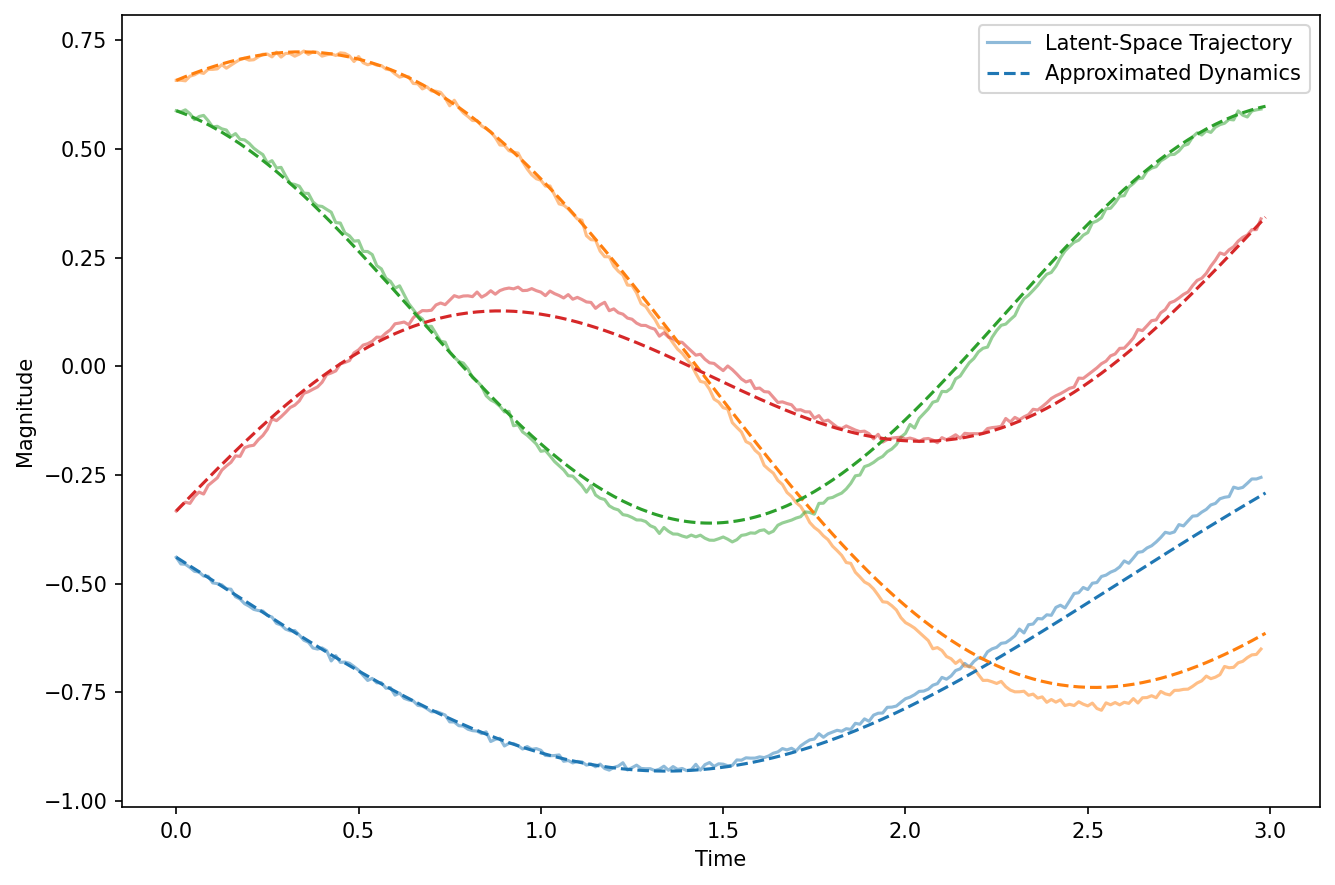

In [66]:
WLaSDI_model = WLaSDI(phi.T, phi, NN = False, Local = False, nearest_neigh= 9, Coef_interp=True, Coef_interp_method=Rbf)
normal = np.amax(np.abs(latent_space_SS))
WLaSDI_model_coef = WLaSDI_model.train_dynamics(latent_space_SS, P, t, degree = 1, normal = normal, L = 10, gamma = 0, overlap = 0.9, LS_vis = True, useGLS=0)

(240, 4)


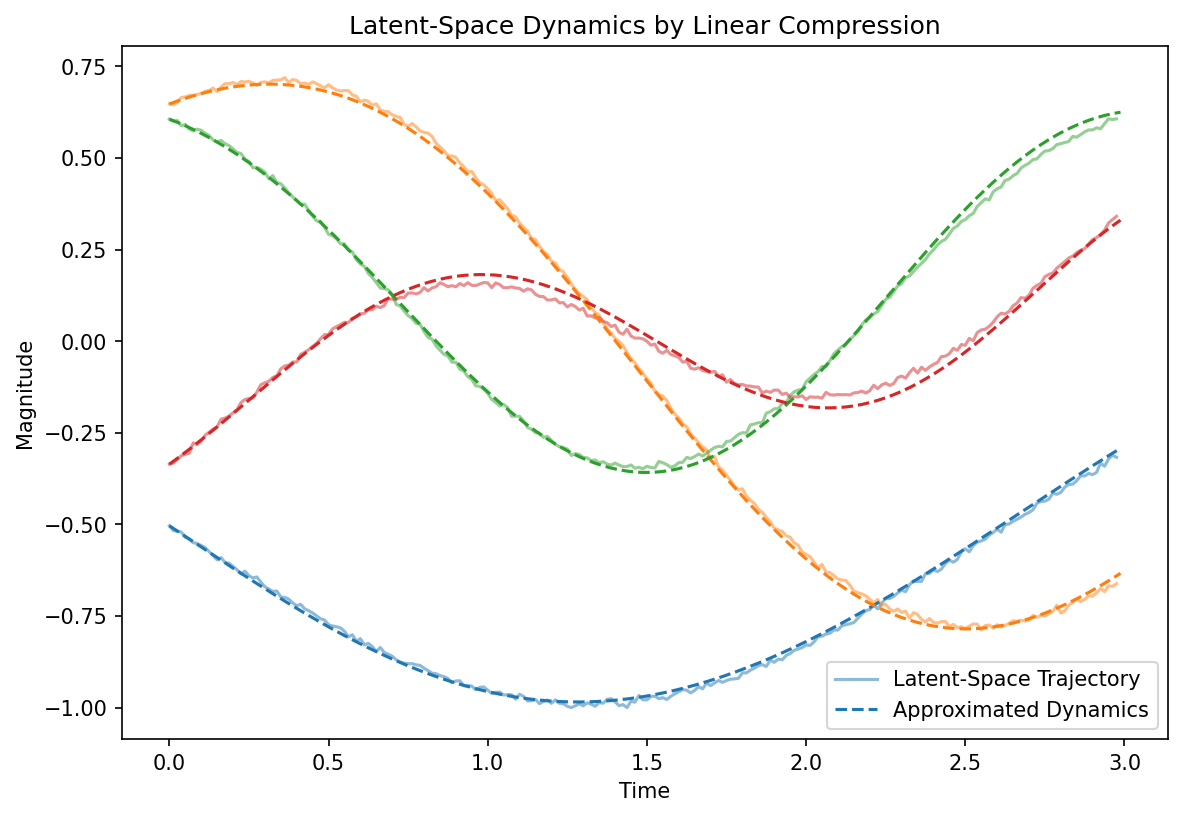

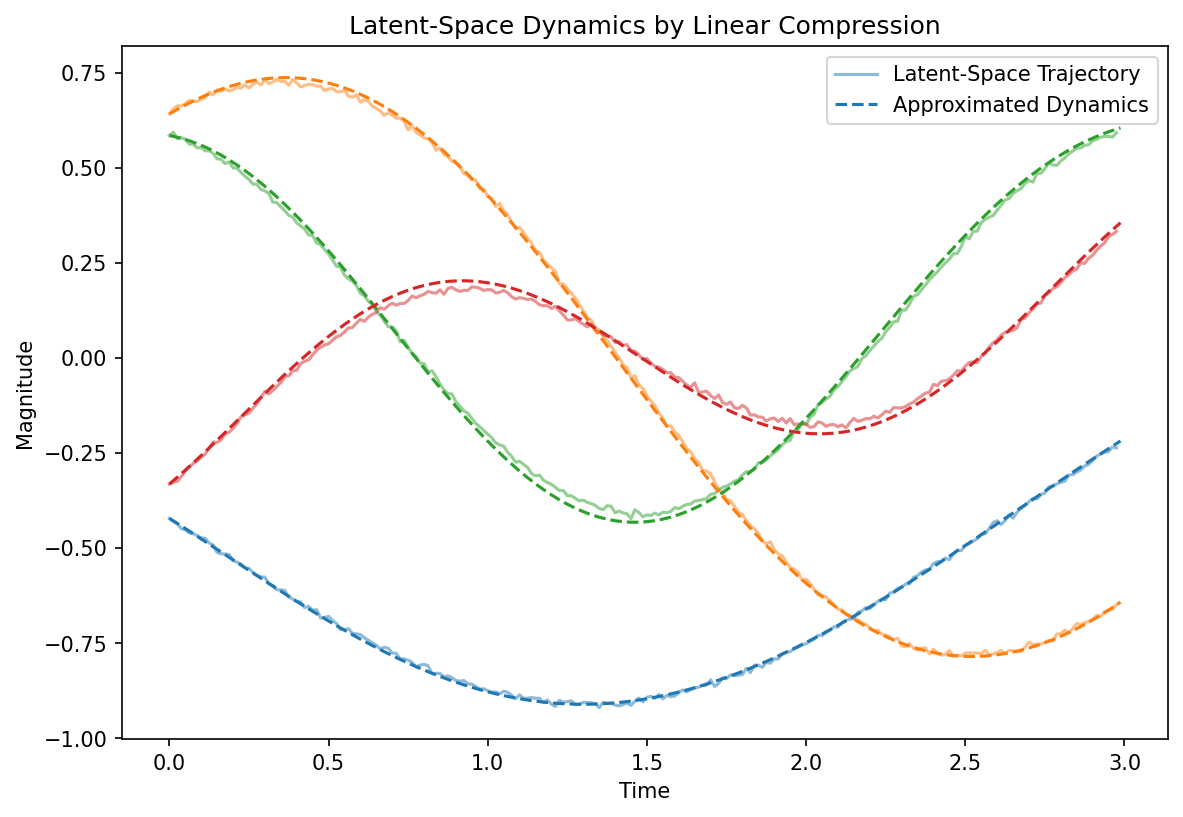

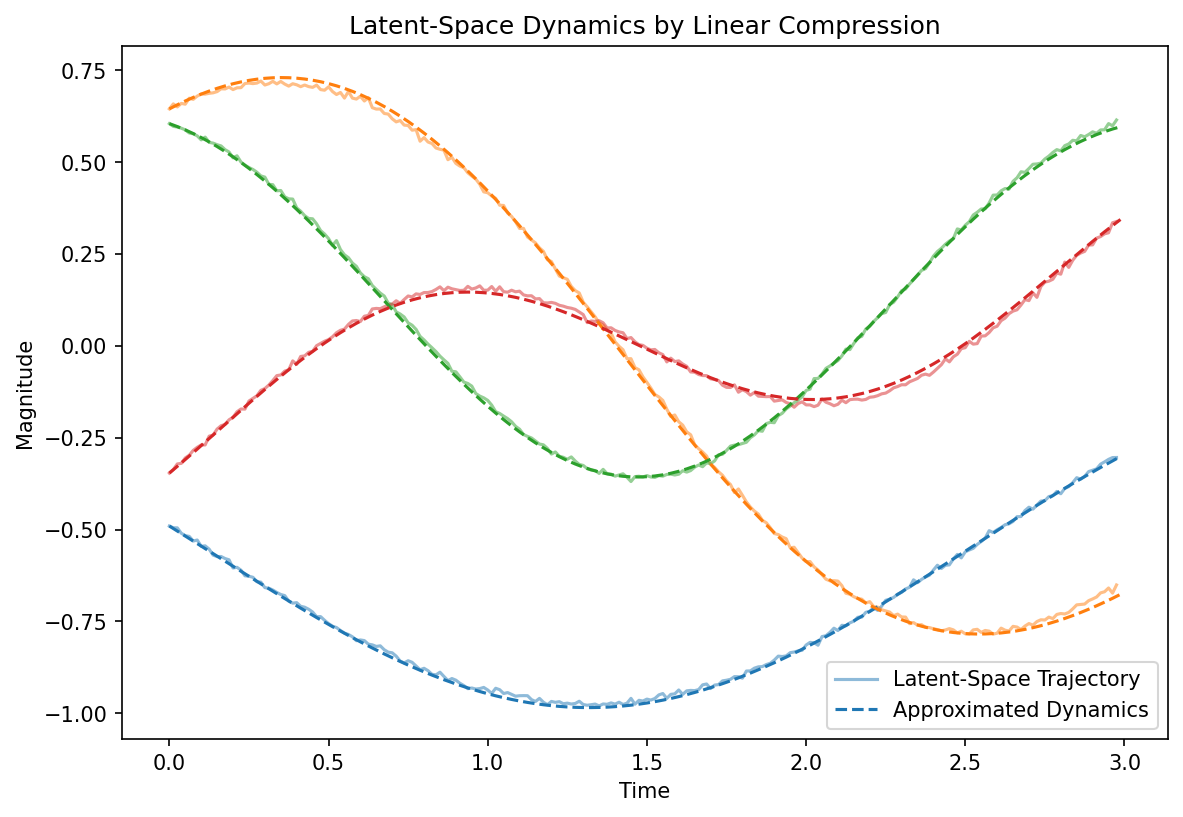

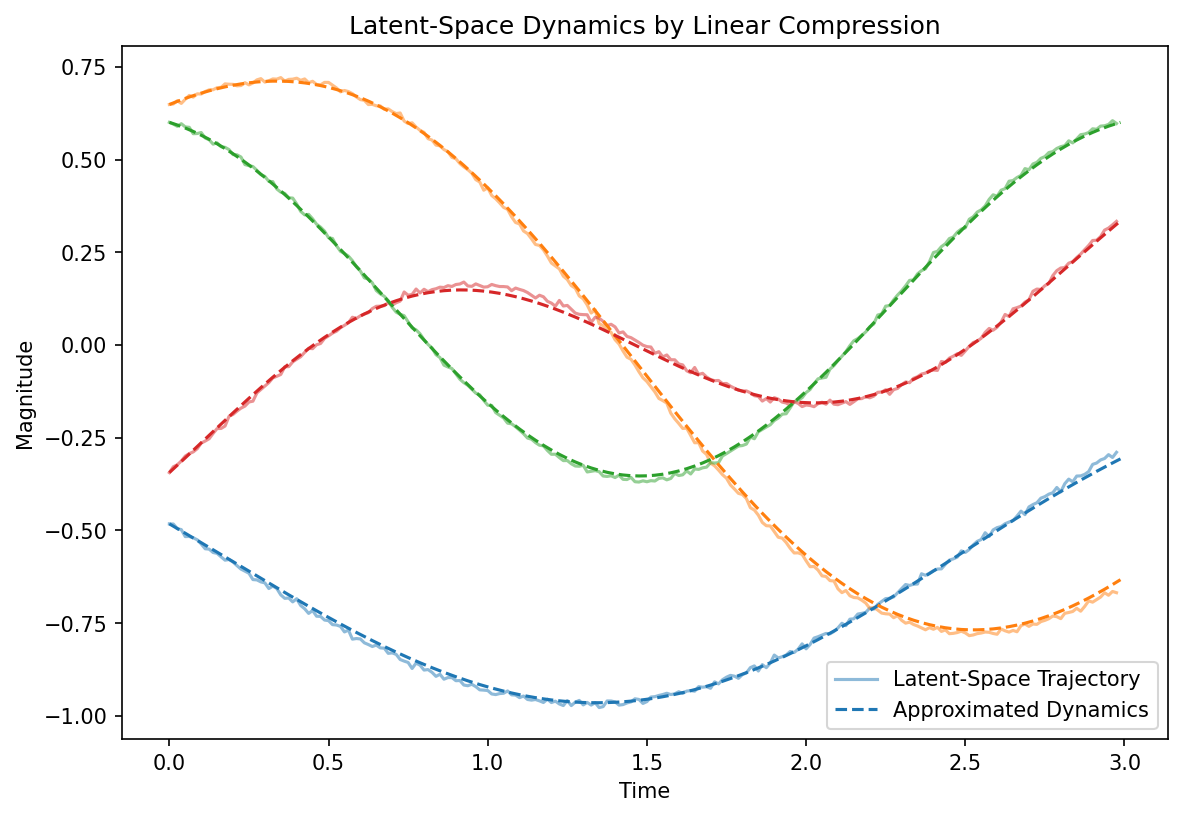

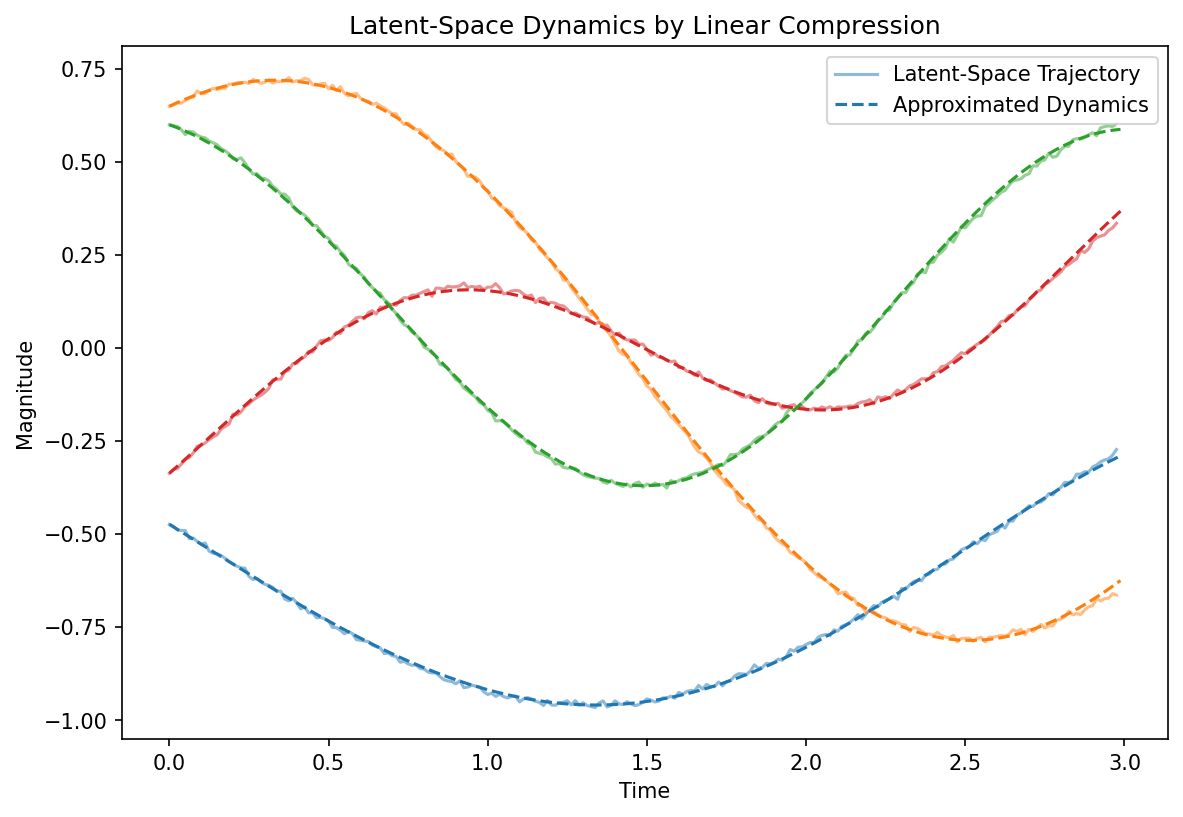

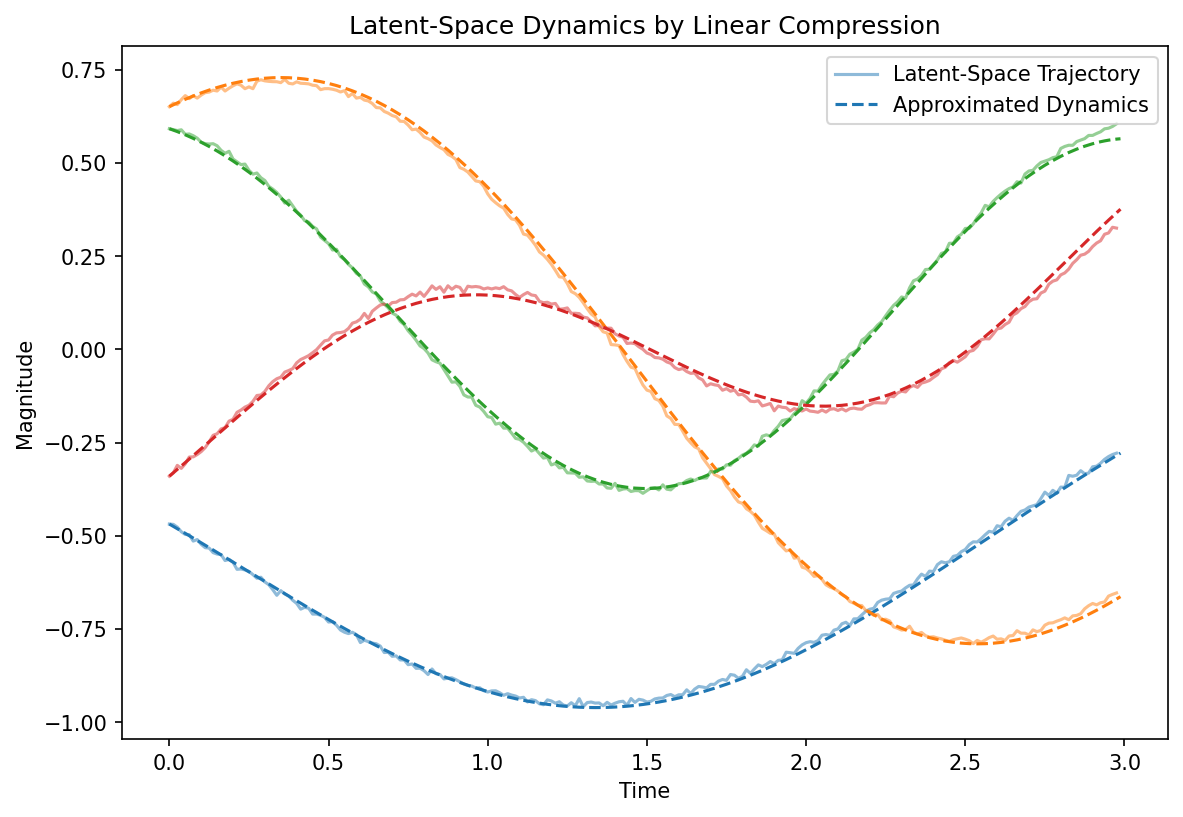

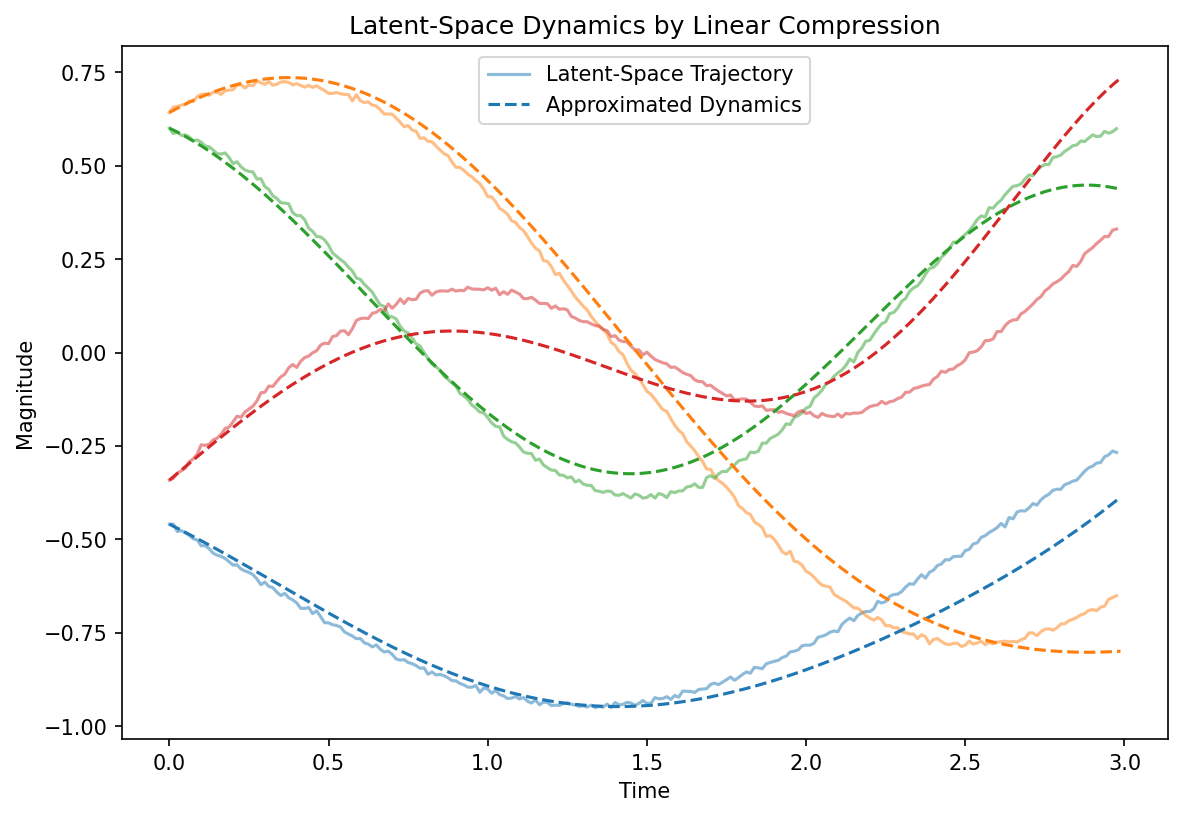

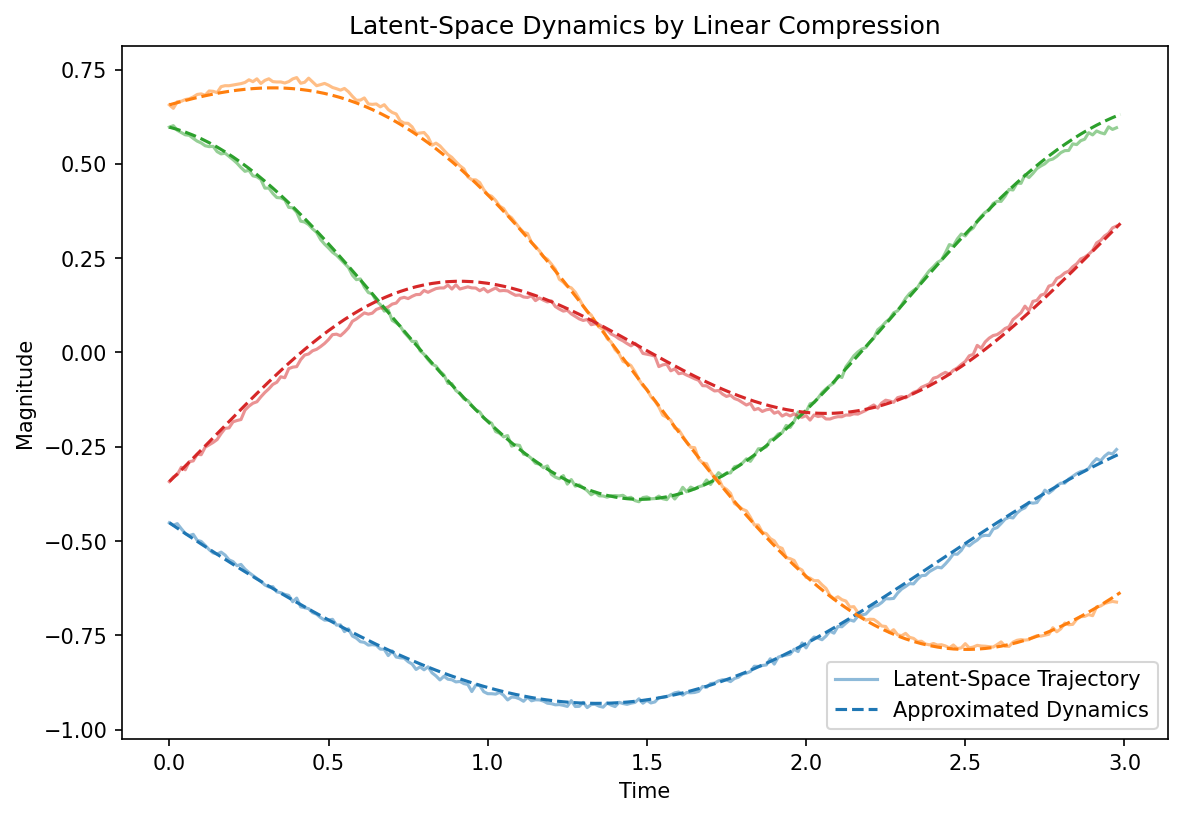

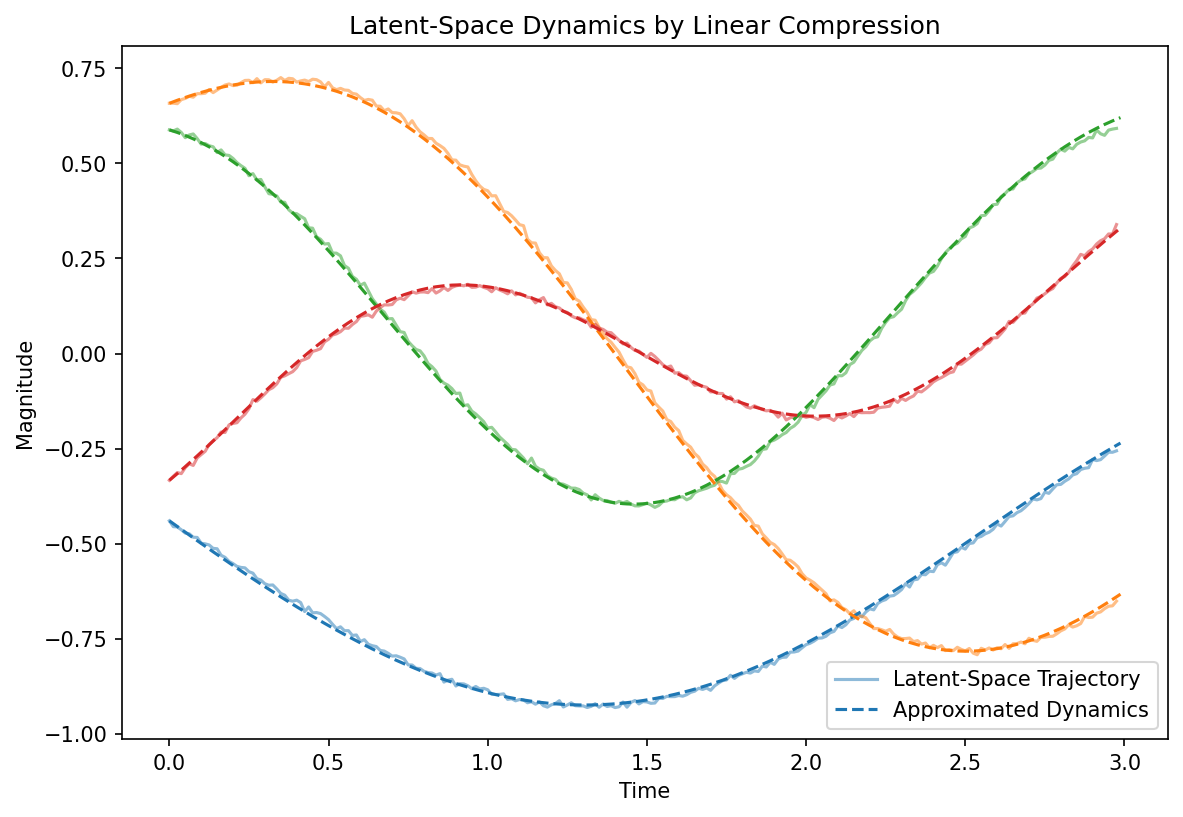

In [58]:
from LaSDI import LaSDI
LaSDI_model = LaSDI(phi.T, phi, NN = False, Local = True, nearest_neigh= 9,  Coef_interp=True, Coef_interp_method=Rbf)
normal = np.amax(np.abs(latent_space_SS))
LaSDI_model_coef = LaSDI_model.train_dynamics(latent_space_SS, P, t, degree = 1, normal = normal)

In [43]:
#Use WENDy
features = [
        [lambda x0, x1, x2, x3: x0*0 + 1, lambda x0, x1, x2, x3: x0, lambda x0, x1, x2, x3: x1, lambda x0, x1, x2, x3: x2, lambda x0, x1, x2, x3: x3, ],
        [lambda x0, x1, x2, x3: x0*0 + 1, lambda x0, x1, x2, x3: x0, lambda x0, x1, x2, x3: x1, lambda x0, x1, x2, x3: x2, lambda x0, x1, x2, x3: x3, ],
        [lambda x0, x1, x2, x3: x0*0 + 1, lambda x0, x1, x2, x3: x0, lambda x0, x1, x2, x3: x1, lambda x0, x1, x2, x3: x2, lambda x0, x1, x2, x3: x3, ],
        [lambda x0, x1, x2, x3: x0*0 + 1, lambda x0, x1, x2, x3: x0, lambda x0, x1, x2, x3: x1, lambda x0, x1, x2, x3: x2, lambda x0, x1, x2, x3: x3, ],
]

degree = 1
WLaSDI_model = WLaSDI_wendy(phi.T, phi, NN = False, Local = True, nearest_neigh=4, Coef_interp=False, Coef_interp_method=Rbf)
normal = np.amax(np.abs(latent_space_SS))
WLaSDI_model_coef = WLaSDI_model.train_dynamics(latent_space_SS, P, t, features = features, normal = normal, gamma = 0.001 ,LS_vis = True, ls_meth = "LS", subsample=1, mt_params=[2**i for i in range(3)], toggle_VVp_svd = np.nan)


Local approach WITHOUT SINDy coefficient interpolation


### Generate ROM and visualize results

In [67]:
FOM_file = np.load('./data/ex9_interp_123.npz', allow_pickle = True)
FOM = FOM_file.f.arr_0
FOM = FOM[:,free_raveled_indicies]
#FOM = addNoise(FOM, noise_level).astype('float32')
start = time.time()
t = np.arange(0,tstop,dt)
FOM_recon = WLaSDI_model.generate_ROM(FOM[0], np.array([1.23,1.0]),t)
WLaSDI_time = time.time()-start
speed_up = 14.5/WLaSDI_time
test = []
for k in range(int(nt-1)):
    test.append(LA.norm(FOM_recon[k].reshape(ny-2,nx-2)-FOM[k].reshape(ny-2,nx-2))/LA.norm(FOM[k].reshape(ny-2,nx-2))*100)
max_re = np.amax(test)

Text(0.5, 1.0, 'Relative Error')

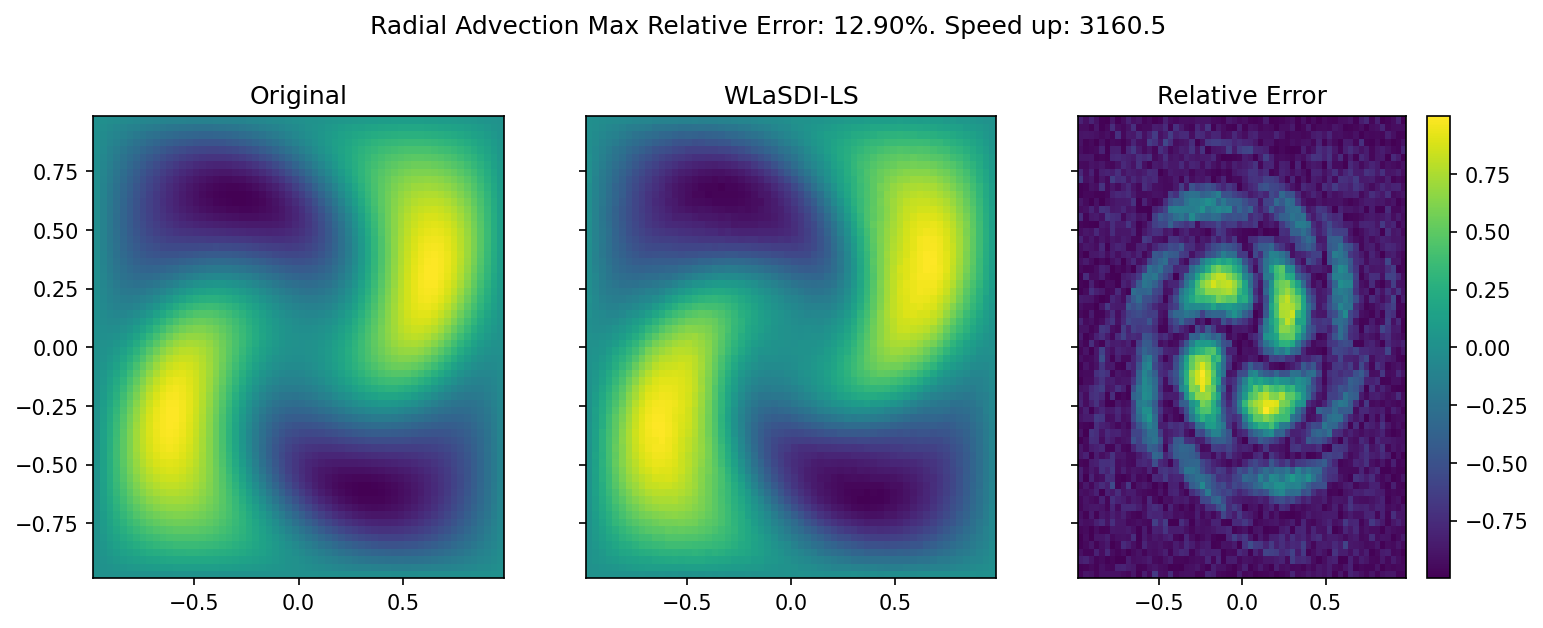

In [68]:
k = 50
plt.rcParams['figure.dpi'] = 150
# plt.figure(figsize=(8, 6), dpi=80)
fig, (ax1,ax2,ax3) = plt.subplots(1,3,sharey = True)
fig.set_size_inches(12,4)

# ax1 = fig.add_subplot(2,3,1)
z=ax1.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),FOM[k].reshape(nx-2,ny-2), shading = 'nearest')
# fig.colorbar(z, ax = ax1)
fig.suptitle('Radial Advection Max Relative Error: {:.2f}%. Speed up: {:.1f}'.format(np.amax(max_re), speed_up), y = 1.05)
ax1.set_title('Original')

# ax2 = fig.add_subplot(2,3,2)
z1=ax2.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),FOM_recon[k].reshape(nx-2,ny-2), shading = 'nearest')
# fig.colorbar(z, ax = ax2)
ax2.set_title('WLaSDI-LS')

# ax3 = fig.add_subplot(2,3,3)
z2=ax3.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),np.abs(FOM_recon[k].reshape(nx-2,ny-2)-FOM[k].reshape(nx-2,ny-2))/LA.norm(FOM[k].reshape(nx-2,ny-2)), shading = 'nearest')
fig.colorbar(z, ax = ax3)
ax3.set_title('Relative Error')

Text(0, 0.5, 'Relative Error (%)')

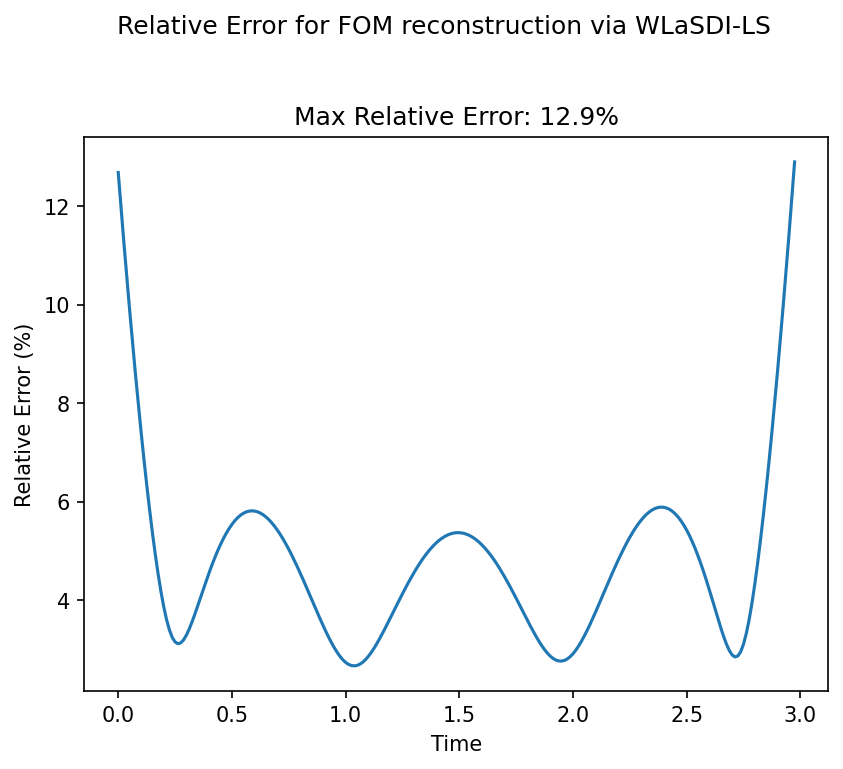

In [69]:
fig = plt.figure()
fig.suptitle('Relative Error for FOM reconstruction via WLaSDI-LS', y = 1.05)
ax = plt.axes()
ax.set_title('Max Relative Error: {:.3}%'.format(np.amax(test)))
ax.plot(t[:-1], test)
ax.set_xlabel('Time')
ax.set_ylabel('Relative Error (%)')